Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

## Load Dataset

In [2]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")

age = [val.left for val in df.age.unique()]
age.sort()

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


## Model training and test

In [3]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

CPU times: total: 1.81 s
Wall time: 1.88 s


array([1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10205
           1       0.75      0.62      0.68      3362

    accuracy                           0.85     13567
   macro avg       0.81      0.77      0.79     13567
weighted avg       0.85      0.85      0.85     13567



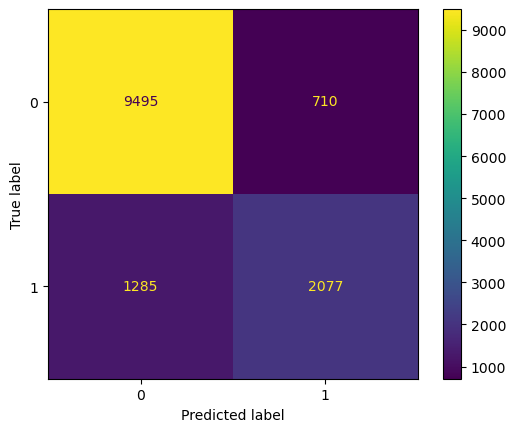

In [6]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [7]:
# #Uncomment if you want to find new rules with different support

# ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
#     X_test,
#     model=model,
#     sensitive_attribute='sex',
#     freqitem_minsupp = 0.01,
#     missing_subgroup_val="Unknown",
#     drop_infeasible = True,
#     drop_above = True
# )

# print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
# rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

In [8]:
from facts.utils import load_rules_by_if, save_rules_by_if

## Use this for loading rules from disk
rules_by_if = load_rules_by_if("rulesAdultFairTest_preproc.data")

## Use this for saving rules on disk
#save_rules_by_if("rulesAdultFairTest_preproc.data", rules_by_if)

In [9]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1][" Male"][1][0][1]-e[1][" Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If Workclass =  Private, age = (34.0, 41.0], capital-loss = 0, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 1.16% covered
		Make age = (41.0, 50.0], occupation =  Exec-managerial with correctness 66.67%.
		Make occupation =  Exec-managerial with correctness 56.41%.
		Make age = (41.0, 50.0], occupation =  Prof-specialty with correctness 66.67%.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with correctness 56.41%.
		Make occupation =  Prof-specialty with correctness 50.00%.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with correctness 56.41%.
		Make age = (41.0, 50.0] with correctness 48.72%.
		Make age = (50.0, 90.0] with correctness 23.08%.
		Make Workclass =  Local-gov, age = (41.0, 50.0], occupation =  Prof-specialty with correctness 56.41%.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 0.00%.
		Make Workclass =  Self-emp-inc, age = (50.0, 90.0], occupation =  Exec-managerial with correctness 66.67%.
		Make occupati

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [11]:
num_features = ['education-num', 'capital-gain', 'capital-loss']
cate_features = ['age', 'Workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ord_features = ['hours-per-week']

feature_weights = {"sex": 1, "age": 1, "relationship": 10, "education-num": 20}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  7.74it/s]


If age = (50.0, 90.0], capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 17.54% covered out of 6709
		Make capital-gain = 15024 with effectiveness 96.94%.
		Make capital-gain = 7298 with effectiveness 70.55%.
		Aggregate cost of the above recourses = -8.06
	Protected Subgroup ' Female', 15.83% covered out of 4051
		Make capital-gain = 15024 with effectiveness 87.08%.
		Make capital-gain = 7298 with effectiveness 28.72%.
		Aggregate cost of the above recourses = -4.87
	Bias against  Female. Unfairness score = 3.19.
	Cumulative effectiveness plot for the above recourses:


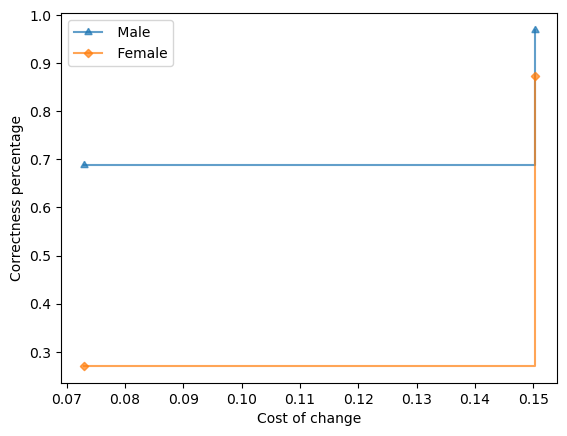

If capital-gain = 0, race =  White:
	Protected Subgroup ' Male', 84.37% covered out of 6709
		Make capital-gain = 15024 with effectiveness 83.44%.
		Make capital-gain = 7688 with effectiveness 54.97%.
		Make capital-gain = 7298 with effectiveness 52.71%.
		Make race =  Asian-Pac-Islander with effectiveness 0.00%.
		Make capital-gain = 99999 with effectiveness 100.00%.
		Make race =  Black with effectiveness 0.00%.
		Make capital-gain = 5178 with effectiveness 40.46%.
		Make capital-gain = 5013 with effectiveness 39.95%.
		Aggregate cost of the above recourses = -4.59
	Protected Subgroup ' Female', 76.74% covered out of 4051
		Make capital-gain = 15024 with effectiveness 74.33%.
		Make capital-gain = 7688 with effectiveness 27.77%.
		Make capital-gain = 7298 with effectiveness 25.45%.
		Make race =  Asian-Pac-Islander with effectiveness 0.00%.
		Make capital-gain = 99999 with effectiveness 100.00%.
		Make race =  Black with effectiveness 0.00%.
		Make capital-gain = 5178 with effectiven

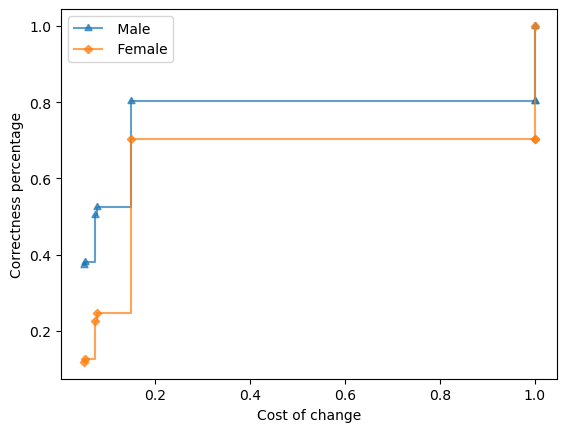

If capital-gain = 0, capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 82.04% covered out of 6709
		Make capital-gain = 15024 with effectiveness 83.02%.
		Make capital-gain = 7688 with effectiveness 54.35%.
		Make capital-gain = 7298 with effectiveness 52.11%.
		Make capital-loss = 1902 with effectiveness 30.62%.
		Make capital-loss = 1887 with effectiveness 30.51%.
		Make capital-loss = 1977 with effectiveness 31.42%.
		Make capital-gain = 99999 with effectiveness 100.00%.
		Make race =  Asian-Pac-Islander with effectiveness 0.00%.
		Make capital-gain = 5178 with effectiveness 40.03%.
		Make race =  Black with effectiveness 0.00%.
		Make capital-gain = 5013 with effectiveness 39.56%.
		Aggregate cost of the above recourses = -3.50
	Protected Subgroup ' Female', 74.50% covered out of 4051
		Make capital-gain = 15024 with effectiveness 73.91%.
		Make capital-gain = 7688 with effectiveness 26.80%.
		Make capital-gain = 7298 with effectiveness 24.54%.
		Make capital-loss = 190

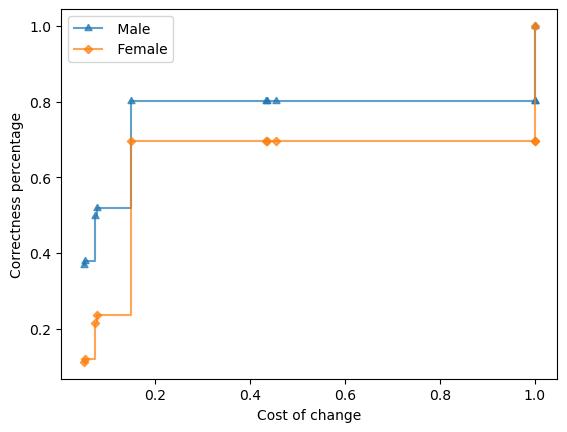

If Workclass =  Private, capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Male', 64.55% covered out of 6709
		Make Workclass =  Self-emp-inc with effectiveness 6.59%.
		Make Workclass =  Local-gov with effectiveness 0.00%.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00%.
		Make Workclass =  Federal-gov with effectiveness 11.42%.
		Make Workclass =  State-gov with effectiveness 0.00%.
		Make capital-gain = 15024 with effectiveness 80.25%.
		Make capital-gain = 7688 with effectiveness 50.95%.
		Make capital-gain = 7298 with effectiveness 48.61%.
		Make capital-gain = 99999 with effectiveness 100.00%.
		Make capital-gain = 5178 with effectiveness 37.70%.
		Aggregate cost of the above recourses = -2.71
	Protected Subgroup ' Female', 69.79% covered out of 4051
		Make Workclass =  Self-emp-inc with effectiveness 1.28%.
		Make Workclass =  Local-gov with effectiveness 0.00%.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00%.
		Make Workclass =

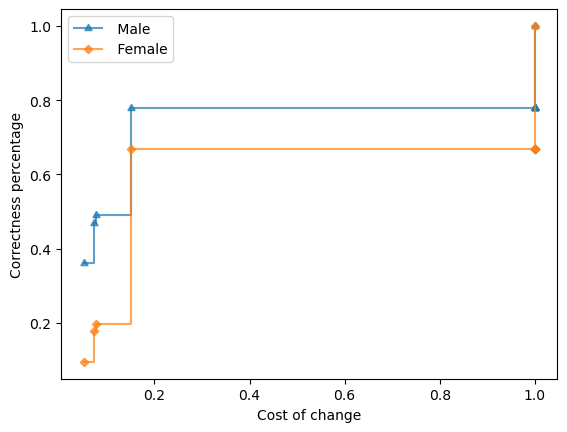

If Workclass =  Private, capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 62.89% covered out of 6709
		Make Workclass =  Self-emp-inc with effectiveness 6.38%.
		Make Workclass =  Local-gov with effectiveness 0.00%.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00%.
		Make Workclass =  Federal-gov with effectiveness 11.08%.
		Make capital-gain = 15024 with effectiveness 79.80%.
		Make Workclass =  State-gov with effectiveness 0.00%.
		Make capital-gain = 7688 with effectiveness 50.23%.
		Make capital-gain = 7298 with effectiveness 47.95%.
		Make capital-loss = 1902 with effectiveness 28.44%.
		Make capital-loss = 1977 with effectiveness 28.84%.
		Make capital-loss = 1887 with effectiveness 28.36%.
		Make capital-gain = 99999 with effectiveness 100.00%.
		Make capital-gain = 5178 with effectiveness 37.22%.
		Aggregate cost of the above recourses = -2.21
	Protected Subgroup ' Female', 67.64% covered out of 4051
		Make Workclass

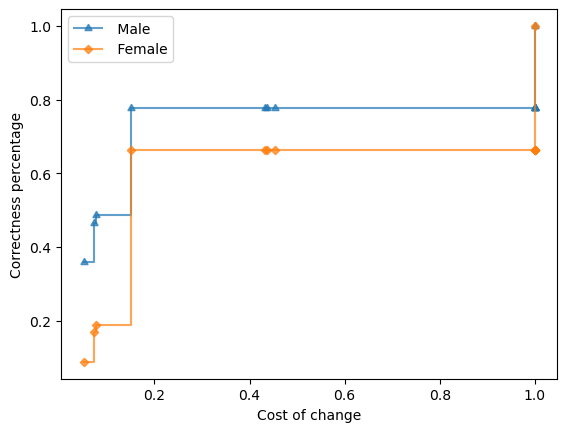

If Workclass =  Private, capital-gain = 0, race =  White:
	Protected Subgroup ' Male', 62.73% covered out of 6709
		Make Workclass =  Self-emp-inc with effectiveness 6.93%.
		Make Workclass =  Local-gov with effectiveness 0.00%.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00%.
		Make Workclass =  Federal-gov with effectiveness 11.85%.
		Make Workclass =  State-gov with effectiveness 0.00%.
		Make capital-gain = 15024 with effectiveness 80.25%.
		Make capital-gain = 7688 with effectiveness 51.48%.
		Make capital-gain = 7298 with effectiveness 49.02%.
		Make race =  Asian-Pac-Islander with effectiveness 0.00%.
		Make capital-gain = 99999 with effectiveness 100.00%.
		Make race =  Black with effectiveness 0.00%.
		Make capital-gain = 5178 with effectiveness 37.96%.
		Aggregate cost of the above recourses = -2.27
	Protected Subgroup ' Female', 61.34% covered out of 4051
		Make Workclass =  Self-emp-inc with effectiveness 1.33%.
		Make Workclass =  Local-gov with effectiveness

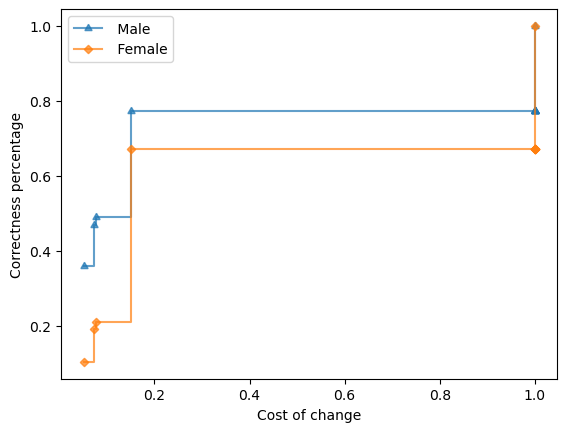

If Workclass =  Private, capital-gain = 0, capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 61.14% covered out of 6709
		Make Workclass =  Self-emp-inc with effectiveness 6.74%.
		Make Workclass =  Local-gov with effectiveness 0.00%.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00%.
		Make Workclass =  Federal-gov with effectiveness 11.52%.
		Make capital-gain = 15024 with effectiveness 79.76%.
		Make Workclass =  State-gov with effectiveness 0.00%.
		Make capital-gain = 7688 with effectiveness 50.78%.
		Make capital-gain = 7298 with effectiveness 48.39%.
		Make capital-loss = 1977 with effectiveness 29.22%.
		Make capital-loss = 1902 with effectiveness 28.81%.
		Make capital-loss = 1887 with effectiveness 28.76%.
		Make capital-gain = 99999 with effectiveness 100.00%.
		Make race =  Asian-Pac-Islander with effectiveness 0.00%.
		Make capital-gain = 5178 with effectiveness 37.55%.
		Aggregate cost of the above recourses = -2.07
	Protected Subgroup ' Female', 5

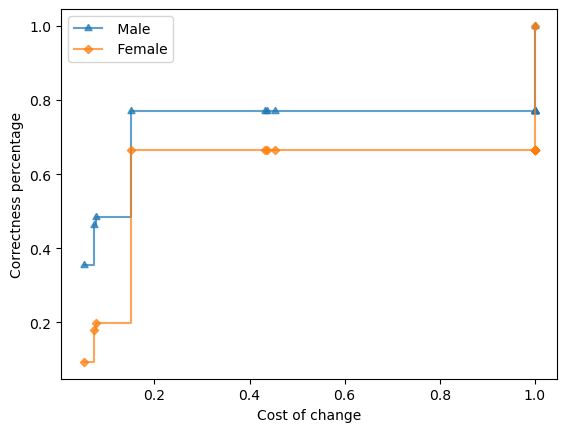

If age = (41.0, 50.0], capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Male', 13.48% covered out of 6709
		Make age = (50.0, 90.0] with effectiveness 0.00%.
		Make capital-gain = 15024 with effectiveness 98.67%.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 97.90%.
		Make capital-gain = 7688 with effectiveness 76.30%.
		Aggregate cost of the above recourses = -4.34
	Protected Subgroup ' Female', 13.86% covered out of 4051
		Make age = (50.0, 90.0] with effectiveness 0.00%.
		Make capital-gain = 15024 with effectiveness 97.40%.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 95.66%.
		Make capital-gain = 7688 with effectiveness 46.18%.
		Aggregate cost of the above recourses = -3.33
	Bias against  Female. Unfairness score = 1.01.
	Cumulative effectiveness plot for the above recourses:


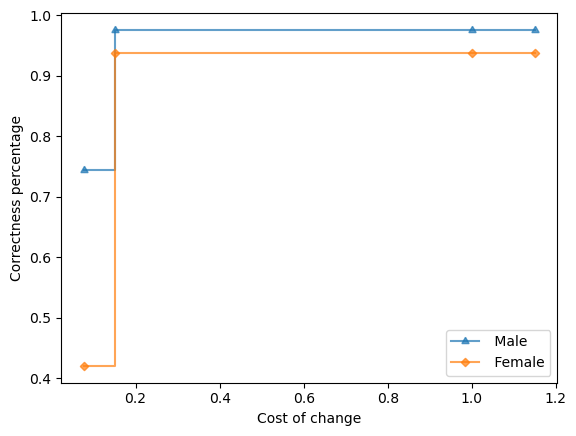

If age = (41.0, 50.0], capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 13.09% covered out of 6709
		Make age = (50.0, 90.0] with effectiveness 0.00%.
		Make capital-gain = 15024 with effectiveness 98.63%.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 97.83%.
		Make capital-gain = 7688 with effectiveness 75.71%.
		Make capital-loss = 1902 with effectiveness 51.08%.
		Aggregate cost of the above recourses = -3.69
	Protected Subgroup ' Female', 13.42% covered out of 4051
		Make age = (50.0, 90.0] with effectiveness 0.00%.
		Make capital-gain = 15024 with effectiveness 97.31%.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 95.52%.
		Make capital-gain = 7688 with effectiveness 44.62%.
		Make capital-loss = 1902 with effectiveness 14.52%.
		Aggregate cost of the above recourses = -2.69
	Bias against  Female. Unfairness score = 1.0.
	Cumulative effectiveness plot for the above recourses:


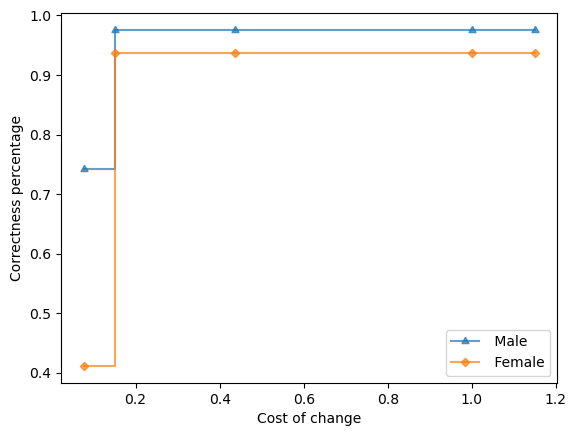

If capital-gain = 0, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Male', 44.01% covered out of 6709
		Make hours-per-week = OverTime with effectiveness 6.04%.
		Make hours-per-week = BrainDrain with effectiveness 6.31%.
		Make hours-per-week = MidTime with effectiveness 0.00%.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 89.42%.
		Make capital-gain = 15024 with effectiveness 86.64%.
		Make capital-gain = 7688 with effectiveness 54.88%.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 58.85%.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 57.16%.
		Make capital-gain = 7298 with effectiveness 52.54%.
		Aggregate cost of the above recourses = -2.45
	Protected Subgroup ' Female', 41.81% covered out of 4051
		Make hours-per-week = OverTime with effectiveness 1.55%.
		Make hours-per-week = BrainDrain with effectiveness 1.55%.
		Make hours-per-week = MidTime with effectiveness 0

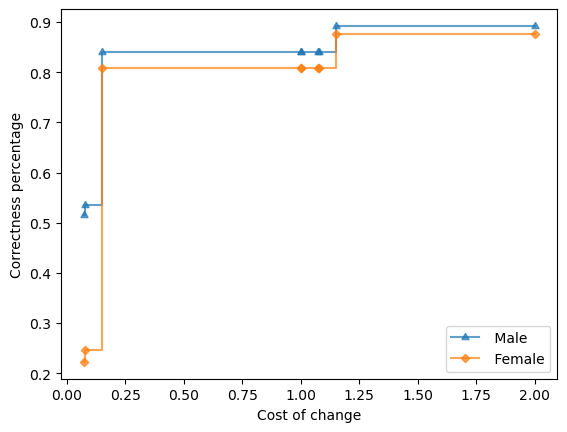

If age = (34.0, 41.0], capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Male', 15.45% covered out of 6709
		Make age = (41.0, 50.0] with effectiveness 8.89%.
		Make age = (50.0, 90.0] with effectiveness 3.09%.
		Make age = (41.0, 50.0], capital-gain = 15024 with effectiveness 98.36%.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 98.26%.
		Make age = (41.0, 50.0], capital-gain = 7688 with effectiveness 73.82%.
		Make capital-gain = 15024 with effectiveness 98.16%.
		Make capital-gain = 7688 with effectiveness 70.24%.
		Aggregate cost of the above recourses = -2.60
	Protected Subgroup ' Female', 14.72% covered out of 4051
		Make age = (41.0, 50.0] with effectiveness 2.78%.
		Make age = (50.0, 90.0] with effectiveness 0.82%.
		Make age = (41.0, 50.0], capital-gain = 15024 with effectiveness 95.92%.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 94.12%.
		Make age = (41.0, 50.0], capital-gain = 7688 with effectiveness 43.95%.

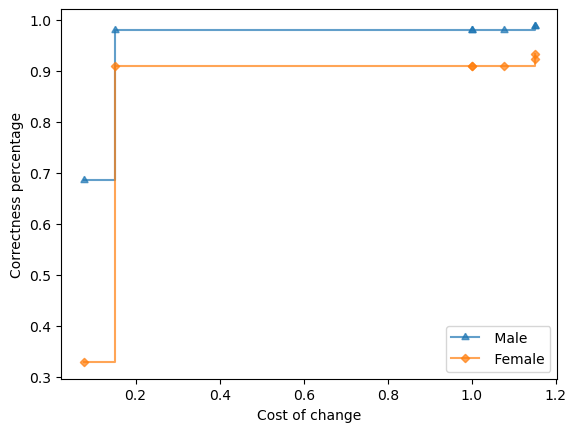

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 37.07% covered out of 6709
		Make hours-per-week = OverTime with effectiveness 6.20%.
		Make hours-per-week = BrainDrain with effectiveness 6.52%.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 89.89%.
		Make hours-per-week = MidTime with effectiveness 0.00%.
		Make capital-gain = 15024 with effectiveness 87.07%.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 60.49%.
		Make capital-gain = 7688 with effectiveness 56.54%.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 58.76%.
		Make capital-gain = 7298 with effectiveness 54.29%.
		Make capital-loss = 1887 with effectiveness 31.98%.
		Make capital-loss = 1902, hours-per-week = OverTime with effectiveness 40.35%.
		Make capital-loss = 1902 with effectiveness 31.98%.
		Aggregate cost of the above recourses = -2.03
	Protect

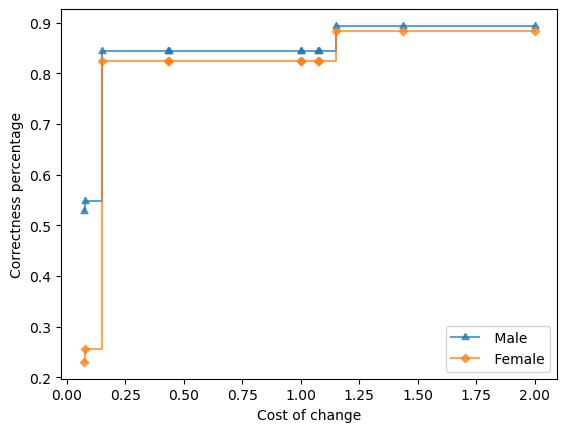

If age = (34.0, 41.0], capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 15.03% covered out of 6709
		Make age = (41.0, 50.0] with effectiveness 8.74%.
		Make age = (50.0, 90.0] with effectiveness 3.08%.
		Make age = (41.0, 50.0], capital-gain = 15024 with effectiveness 98.31%.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 98.21%.
		Make age = (41.0, 50.0], capital-gain = 7688 with effectiveness 73.39%.
		Make capital-gain = 15024 with effectiveness 98.11%.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 52.93%.
		Make capital-gain = 7688 with effectiveness 69.71%.
		Aggregate cost of the above recourses = -2.31
	Protected Subgroup ' Female', 14.43% covered out of 4051
		Make age = (41.0, 50.0] with effectiveness 2.67%.
		Make age = (50.0, 90.0] with effectiveness 0.83%.
		Make age = (41.0, 50.0], capital-gain = 15024 with effectiveness 95.83%.
		Make age = (50.0, 90.0], capital-gain = 15024 with eff

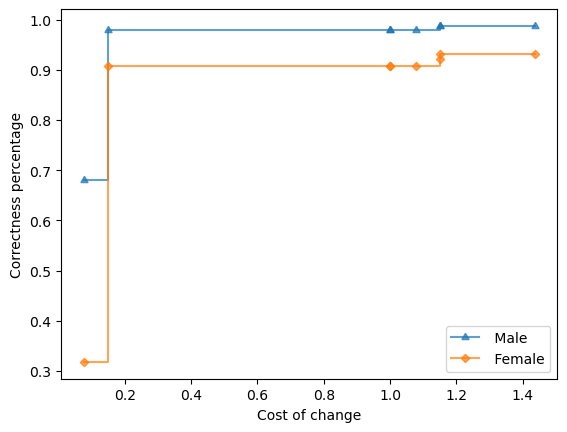

If capital-gain = 0, hours-per-week = OverTime, native-country =  United-States:
	Protected Subgroup ' Male', 19.21% covered out of 6709
		Make hours-per-week = FullTime with effectiveness 0.00%.
		Make hours-per-week = BrainDrain with effectiveness 1.32%.
		Make hours-per-week = MidTime with effectiveness 0.00%.
		Make capital-gain = 15024 with effectiveness 94.33%.
		Make capital-gain = 15024, hours-per-week = FullTime with effectiveness 92.00%.
		Make capital-gain = 7688, hours-per-week = FullTime with effectiveness 63.64%.
		Make capital-gain = 7688 with effectiveness 67.60%.
		Make capital-gain = 7298 with effectiveness 65.42%.
		Make capital-gain = 7298, hours-per-week = FullTime with effectiveness 61.46%.
		Aggregate cost of the above recourses = -2.89
	Protected Subgroup ' Female', 10.46% covered out of 4051
		Make hours-per-week = FullTime with effectiveness 0.00%.
		Make hours-per-week = BrainDrain with effectiveness 0.00%.
		Make hours-per-week = MidTime with effectiveness 0

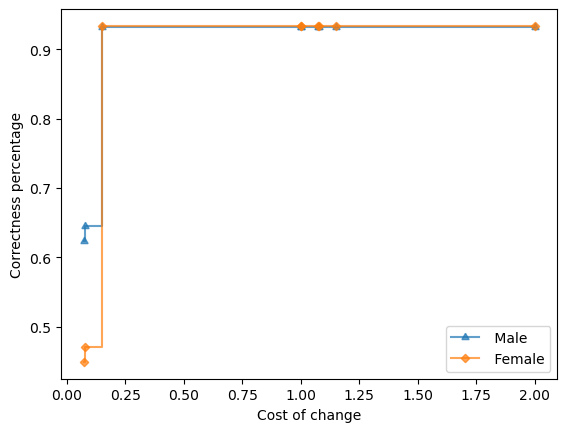

In [11]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
    ],
    cor_threshold=None,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

## Minimum cost above threshold

In [12]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    cor_threshold=0.5,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If age = (26.0, 34.0], capital-loss = 0, education-num = 10, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.31% covered out of 6709
		Make age = (41.0, 50.0], education-num = 12, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 62.50%.
		Aggregate cost of the above recourses = 52.00
	Protected Subgroup ' Female', 1.11% covered out of 4051
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 52.17%.
		Aggregate cost of the above recourses = 12.00
	Bias against  Male. Unfairness score = 40.0.
If education-num = 9, marital-status =  Married-civ-spouse, occupation =  Adm-clerical, race =  White:
	Protected Subgroup ' Male', 1.02% covered out of 6709
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 70.59%.
		Make education-num = 10, occupation =  Prof-specialty with effectiveness 55.88%.
		Aggregate cost of the above recourses = 21

## Mean cost above threshold

In [13]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        "remove-fair-rules",
        # "keep-only-min-change"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If capital-loss = 0:
	Protected Subgroup ' Male', 97.33% covered out of 6709
		Make capital-loss = 1902 with effectiveness 29.69%.
		Make capital-loss = 1887 with effectiveness 29.56%.
		Make capital-loss = 1977 with effectiveness 30.52%.
		Aggregate cost of the above recourses = 0.44
	Protected Subgroup ' Female', 97.43% covered out of 4051
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Bias against  Female. Unfairness score = inf.
If capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 84.79% covered out of 6709
		Make capital-loss = 1902 with effectiveness 31.14%.
		Make capital-loss = 1887 with effectiveness 31.00%.
		Make capital-loss = 1977 with effectiveness 31.95%.
		Aggregate cost of the above recourses = 0.44
	Protected Subgroup ' Female', 77.46% covered out of 4051
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Bias against  Female. Unfairness score = inf.
If Workclass =  Private, capital-loss = 0:


## Number above threshold

In [14]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If age = (26.0, 34.0], hours-per-week = FullTime, occupation =  Sales:
	Protected Subgroup ' Male', 1.07% covered out of 6709
		Make age = (41.0, 50.0], hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 45.83%.
		Make age = (34.0, 41.0], hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 44.44%.
		Make age = (41.0, 50.0], occupation =  Prof-specialty with effectiveness 43.06%.
		Make age = (41.0, 50.0], hours-per-week = OverTime, occupation =  Prof-specialty with effectiveness 45.83%.
		Make age = (41.0, 50.0], occupation =  Exec-managerial with effectiveness 44.44%.
		Make age = (34.0, 41.0], hours-per-week = OverTime, occupation =  Prof-specialty with effectiveness 43.06%.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with effectiveness 22.22%.
		Make age = (34.0, 41.0], occupation =  Exec-managerial with effectiveness 29.17%.
		Make age = (41.0, 50.0], hours-per-week = OverTime with effectiveness 43.06%.
		Make hours-per-w